# Cargar librerias

In [ ]:
!pip install numpy==1.23.5 nonconformist river


import numpy as np

random_state = np.random.RandomState(42)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Regresión

## Datasets

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

def generateRegressionDataSet(intercept=[1,0], domain=range(0,100), noise=[0 for x in range(0,100)], columns=['x', 'y']):
  data = []
  for x, single_noise in zip(domain, noise):
    data.append([x, x*intercept[0]+intercept[1]+ single_noise])
  return pd.DataFrame(data, columns=columns)

def mergeDataSetsSudden(dataset1, dataset2):
  res = []
  for data in dataset1.values.tolist():
    res.append(data)
  for data in dataset2.values.tolist():
    res.append(data)
  return pd.DataFrame(data=res, columns=dataset1.columns)

def generateRegressionDataSetWithSuddenDrift(intercept, domain=[range(0,100), range(100,200)], noise=[[0 for x in range(0,100)], [0 for x in range(0,100)]], columns=['x', 'y']):
  datasets = []
  for d in zip(domain, noise, intercept):
    dataset = generateRegressionDataSet(intercept=d[2], domain=d[0], noise=d[1], columns=columns)
    datasets.append(dataset)
  return reduce(mergeDataSetsSudden, datasets)

def generateRegressionWithGradualDrift(intercept, domain=[range(0,130), range(70,200)], transition_in=[1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,1,0,0], transition_out=[0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0,0,1,1], noise=[[0 for x in range(0,130)], [0 for x in range(0,130)]], columns=['x', 'y']):
  datasets = []
  for d in zip(domain, noise, intercept):
    dom = [x for index, x in enumerate(d[0]) if ((index < len(transition_in) and transition_in[index] == 1) or (index > len(transition_in) and index<len(d[0])-len(transition_out)) or (index>len(d[0])-len(transition_out) and transition_out[index - len(d[0])+len(transition_out)] == 1))] 
    nos = [x for index, x in enumerate(d[1]) if ((index < len(transition_in) and transition_in[index] == 1) or (index > len(transition_in) and index<len(d[1])-len(transition_out)) or (index>len(d[1])-len(transition_out) and transition_out[index - len(d[1])+len(transition_out)] == 1))] 
    dataset = generateRegressionDataSet(intercept=d[2], domain=dom, noise=nos, columns=columns)
    datasets.append(dataset)    
  return reduce(mergeDataSetsSudden, datasets) 

def mergeDataSetsIncremental(dataset1, dataset2, combine_fn, steps=20):
  res = []
  for data in dataset1.values.tolist()[0:len(dataset1)-steps]:
    res.append(data)
  for i in range(0,steps):
    item1 = dataset1.values.tolist()[len(dataset1)-steps + i]
    item2 = dataset2.values.tolist()[i]
    res.append(combine_fn(item1, item2, i, steps))
  for data in dataset2.values.tolist()[steps:]:
    res.append(data)
  return pd.DataFrame(data=res, columns=dataset1.columns)

def generateRegressionDataSetWithIncrementalDrift(intercept, combine_fn, domain=[range(0,110), range(90,200)], noise=[[0 for x in range(0,110)], [0 for x in range(0,110)]], columns=['x', 'y']):
  datasets = []
  for d in zip(domain, noise, intercept):
    dataset = generateRegressionDataSet(intercept=d[2], domain=d[0], noise=d[1], columns=columns)
    datasets.append(dataset)
  return reduce(lambda d1, d2: mergeDataSetsIncremental(d1, d2, combine_fn=combine_fn, steps=20), datasets)

def normalizeData(dataset):
  return (dataset-dataset.mean())/dataset.std()





### Datasets

* Problema de regresión
* 1 variable dependiente
* 1 variable independiente
* Ruido aleatorio con distribución normal (Media: 0)
* 3 Funciones:
  * Función plana con salto
  * Función con pendiente con salto y cambio de pendiente
  * Función con pendiente continua en el cambio de pendiente
* Cada función anterior con diferentes tipos de Drift
  * Abrupto
  * Incremental
  * Gradual



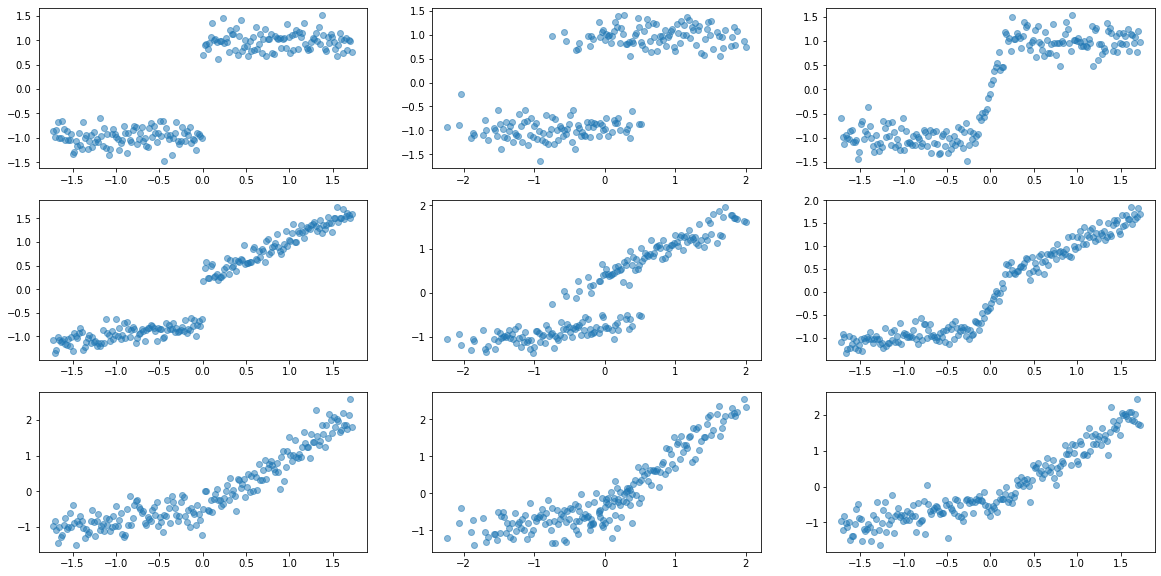

In [ ]:
def combine_sum(item1, item2, pos, steps):
  return [item1[0], (1 - pos/steps)*item1[1] + (pos/steps)*item2[1]]

datasets = [
    [
      normalizeData(generateRegressionDataSetWithSuddenDrift(intercept=[[0,10], [0,30]], noise=[random_state.normal(0,2, 100), random_state.normal(0,2, 100)])),
      normalizeData(generateRegressionWithGradualDrift(intercept=[[0,10], [0,30]], noise=[random_state.normal(0,2, 130), random_state.normal(0,2, 130)])),
      normalizeData(generateRegressionDataSetWithIncrementalDrift(intercept=[[0,10], [0,30]], combine_fn=combine_sum, noise=[random_state.normal(0,2, 130), random_state.normal(0,2, 130)]))
    ],
     [
      normalizeData(generateRegressionDataSetWithSuddenDrift(intercept=[[1,0], [4,0]], noise=[random_state.normal(0,40, 100), random_state.normal(0,40, 100)])),
      normalizeData(generateRegressionWithGradualDrift(intercept=[[1,0], [4,0]], noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)])),
      normalizeData(generateRegressionDataSetWithIncrementalDrift(intercept=[[1,0], [4,0]], combine_fn=combine_sum, noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)]))
    ],
     [
      normalizeData(generateRegressionDataSetWithSuddenDrift(intercept=[[1,0], [4,-300]], noise=[random_state.normal(0,40, 100), random_state.normal(0,40, 100)])),
      normalizeData(generateRegressionWithGradualDrift(intercept=[[1,0], [4,-300]], noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)])),
      normalizeData(generateRegressionDataSetWithIncrementalDrift(intercept=[[1,0], [4,-300]], combine_fn=combine_sum, noise=[random_state.normal(0,40, 130), random_state.normal(0,40, 130)]))
    ]
]

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20,10))

for ax_row, dataset_row in zip(axs, datasets):
  for ax, dataset in zip(ax_row, dataset_row):
    ax.scatter(x=dataset['x'], y=dataset['y'], alpha=0.5)

plt.show()

## Métodos de cálculo de incertidumbre

### Incertidumbre por cuartiles

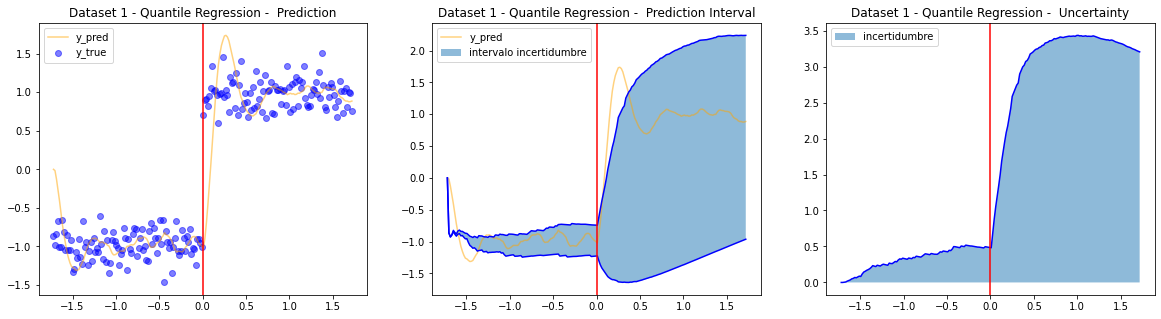

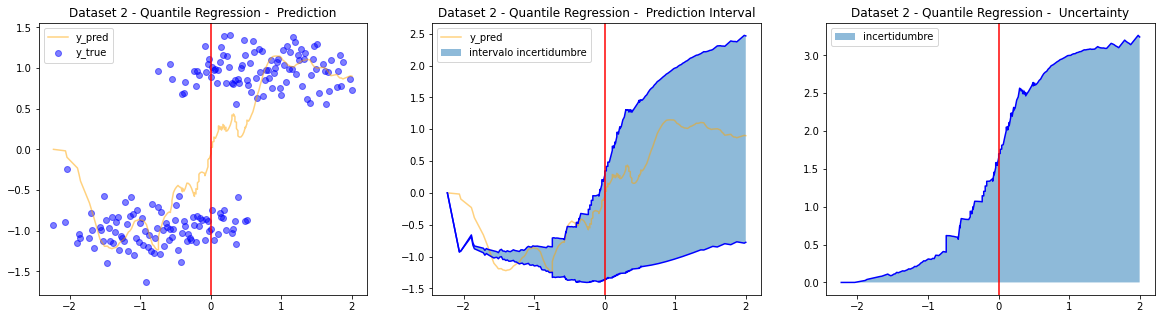

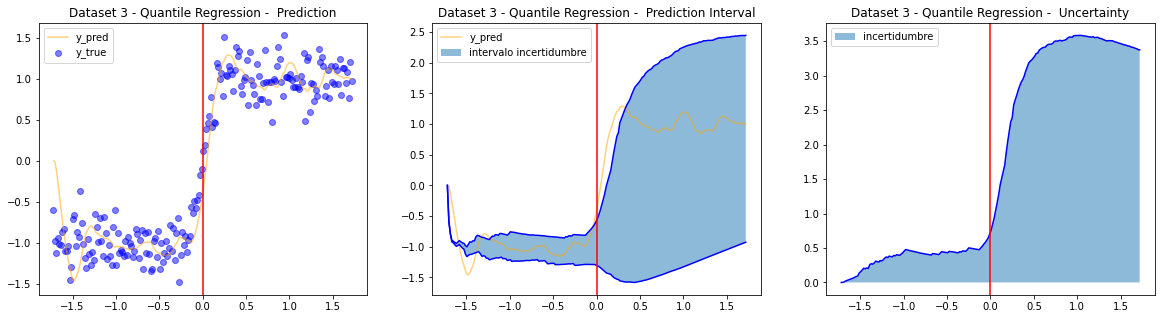

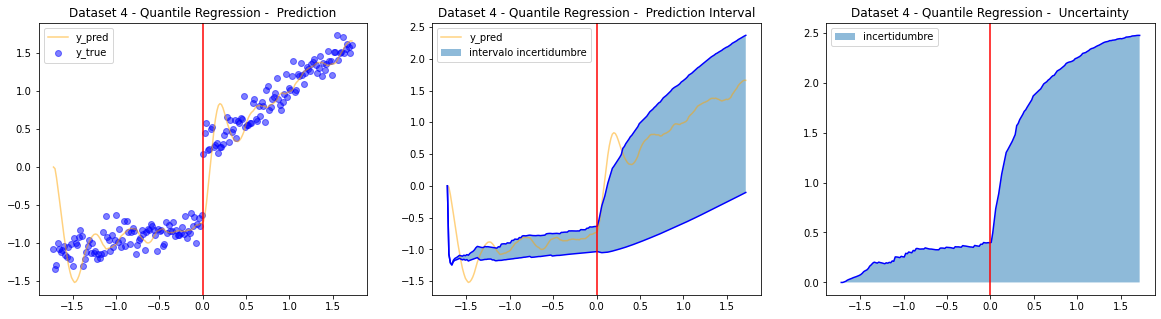

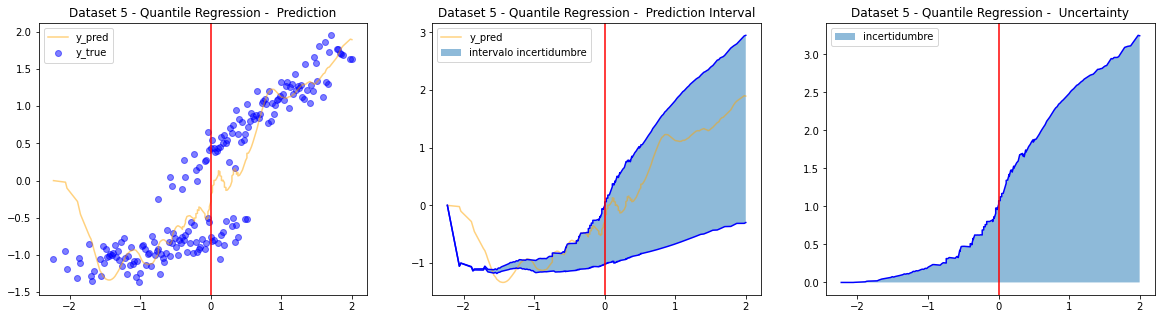

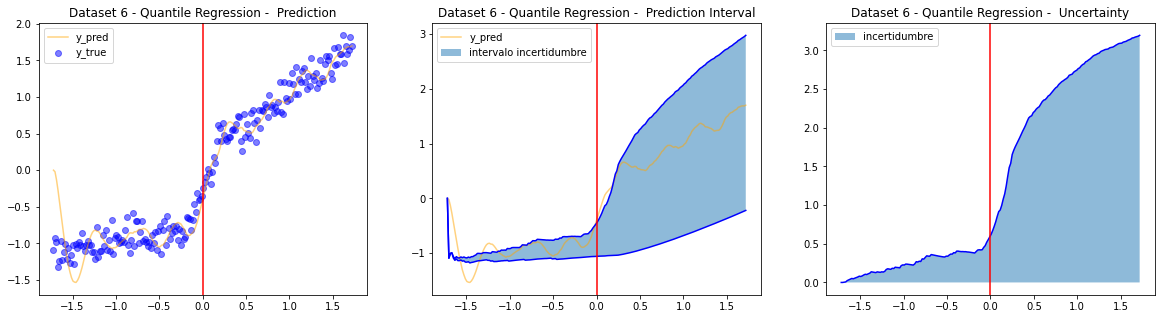

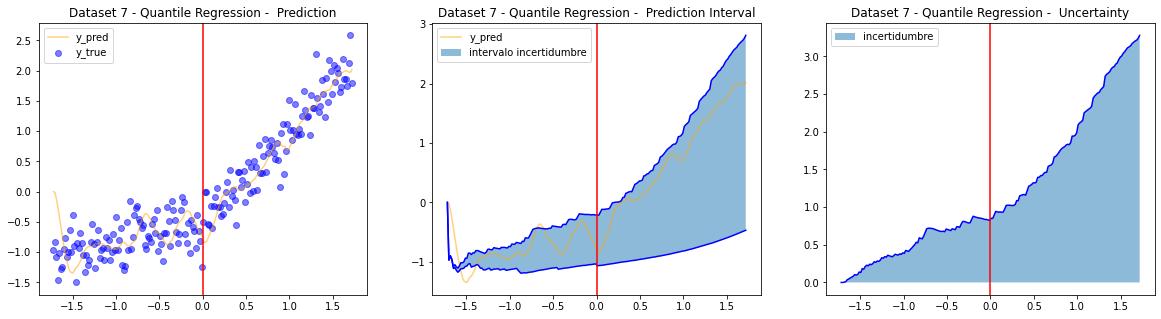

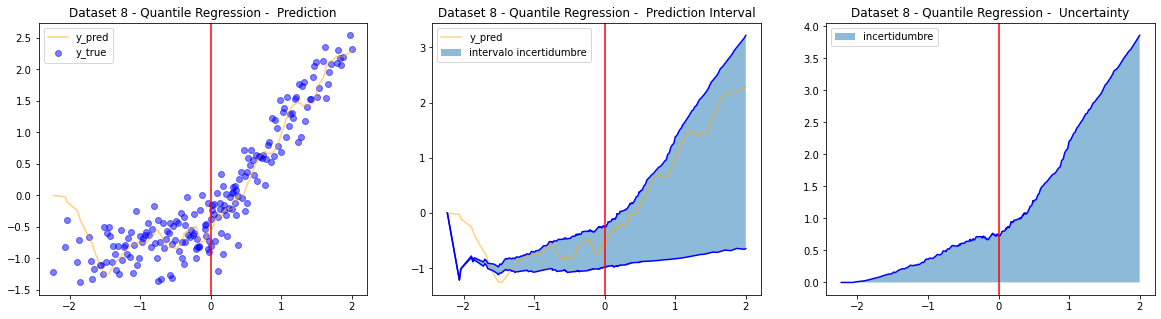

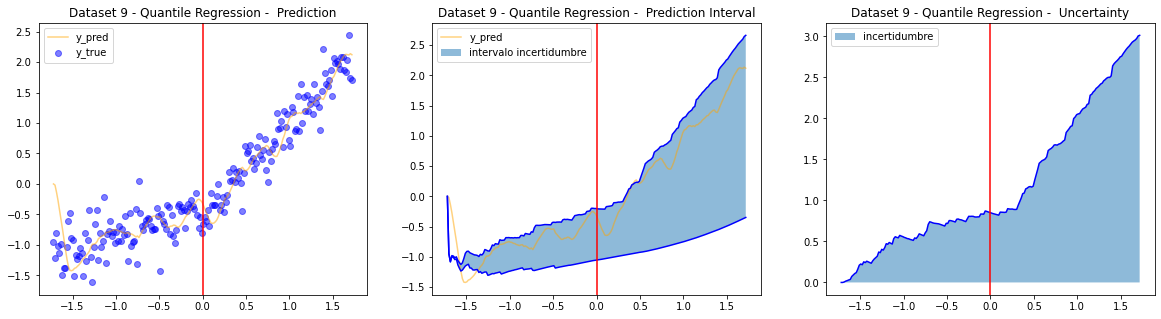

In [ ]:
from river.datasets import synth
from river import compose
from river import preprocessing
from river import linear_model
from river import optim
from river import stats
from river import utils




def getUncertaintyByQuantiles(dataset):
  sorted_dataset = dataset.sort_values(by=['x'])
  X = list(map(lambda x: {'x': x}, sorted_dataset['x']))
  Y =  sorted_dataset['y'].values.tolist()
  model = preprocessing.StandardScaler() | linear_model.LinearRegression(optimizer=optim.Adam())

  uncert = { 
      'uncert95': preprocessing.StandardScaler() | preprocessing.TargetStandardScaler(
          regressor=linear_model.LinearRegression(intercept_lr=0, optimizer=optim.SGD(0.03), loss=optim.losses.Quantile(alpha=0.95))),
      'uncert05': preprocessing.StandardScaler() | preprocessing.TargetStandardScaler(
          regressor=linear_model.LinearRegression(intercept_lr=0, optimizer=optim.SGD(0.03), loss=optim.losses.Quantile(alpha=0.05)))
  }
  res = {'x': [], 'y':[], 'uncert95': [], 'uncert05':[], 'metric': [], 'y_pred':[]}
  
  for x,y in zip(X,Y):
    res.get('x').append(x.get('x'))
    res.get('y').append(y)
    y_pred = model.predict_one(x)
    res.get('y_pred').append(y_pred)
    model.learn_one(x,y)


    for key in uncert.keys():
      uncert_model = uncert.get(key)
      y_pred = uncert_model.predict_one(x)
      res.get(key).append(y_pred)
      uncert_model.learn_one(x,y)
  return res


def showUncertainty(data, drifts=[], titles=['', '', '']):
  diff = []
  for u95, u05 in zip(data.get('uncert95'), data.get('uncert05')):
    diff.append(u95-u05)
   
  fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
  ax[0].scatter(data.get('x'), data.get('y'), color="blue", label="y_true", alpha=0.5)
  ax[0].plot(data.get('x'), data.get('y_pred'), color="orange", label="y_pred", alpha=0.5)
  ax[0].legend()
  ax[0].set_title(titles[0]+" Prediction")
  for drift in drifts:
    ax[0].axvline(x=drift, color='red')
  ax[1].fill_between(x = data.get('x'), y1 = data.get('uncert05'), y2 = data.get('uncert95'), alpha=0.5, label="intervalo incertidumbre")
  ax[1].plot(data.get('x'), data.get('y_pred'), color="orange", label="y_pred", alpha=0.5)
  ax[1].plot(data.get('x'), data.get('uncert05'), color="blue")
  ax[1].plot(data.get('x'), data.get('uncert95'), color="blue")
  ax[1].legend()
  ax[1].set_title(titles[1]+ " Prediction Interval")
  for drift in drifts:
    ax[1].axvline(x=drift, color='red')
  ax[2].fill_between(x= data.get('x'), y1=0, y2=diff, label="incertidumbre", alpha=0.5)
  ax[2].plot(data.get('x'), diff, color="blue")
  ax[2].legend()
  for drift in drifts:
    ax[2].axvline(x=drift, color='red')
  ax[2].set_title(titles[2]+ " Uncertainty")

def showUncertaintyByQuantiles(dataset, drifts = [], titles=['', '', '']):
  data = getUncertaintyByQuantiles(dataset)
  showUncertainty(data, drifts, titles)

for index, dataset in  enumerate([item for sublist in datasets for item in sublist]):
  showUncertaintyByQuantiles(dataset, drifts=[0], titles=['Dataset {} - Quantile Regression - '.format(index+1),'Dataset {} - Quantile Regression - '.format(index+1),'Dataset {} - Quantile Regression - '.format(index+1)])


### Incertidumbre por NonConformist

<ipython-input-4-dc6da21d41f9>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
<ipython-input-4-dc6da21d41f9>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
<ipython-input-4-dc6da21d41f9>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

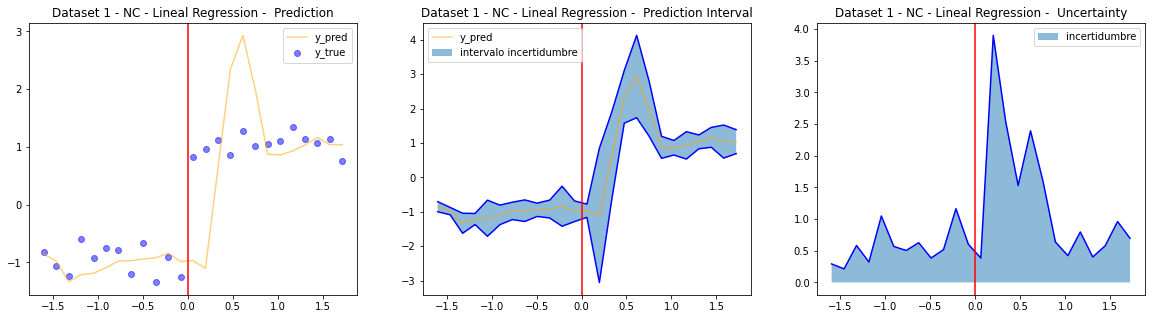

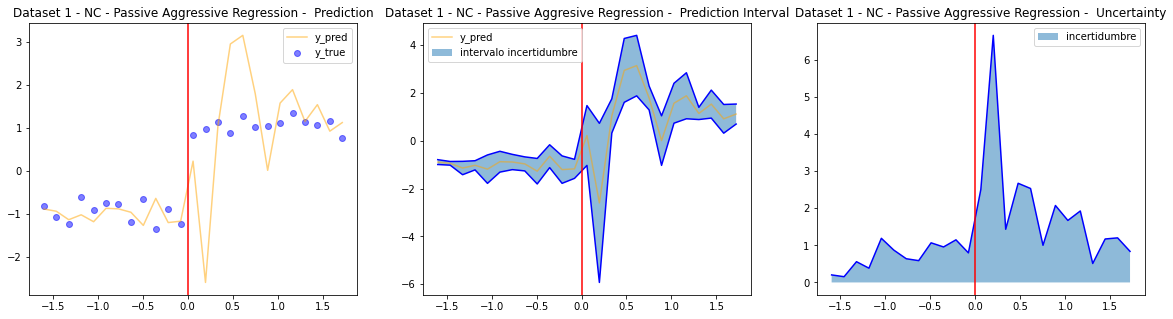

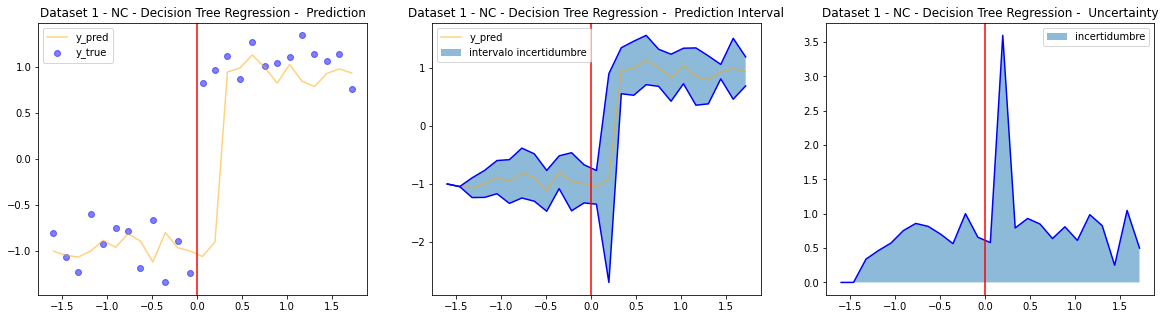

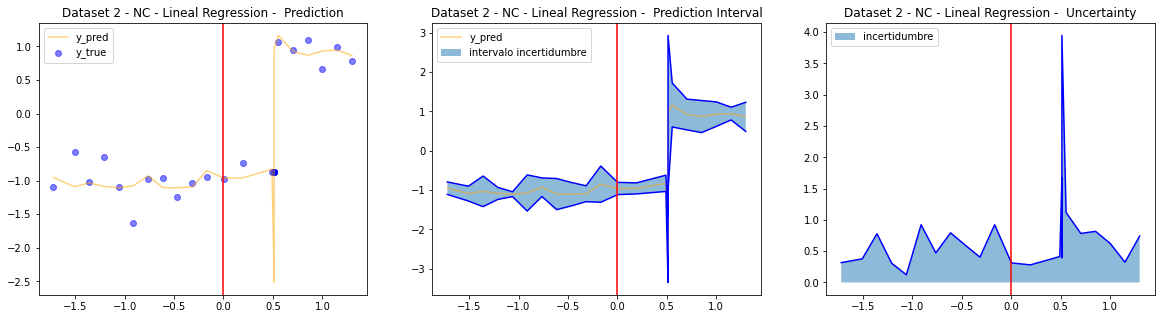

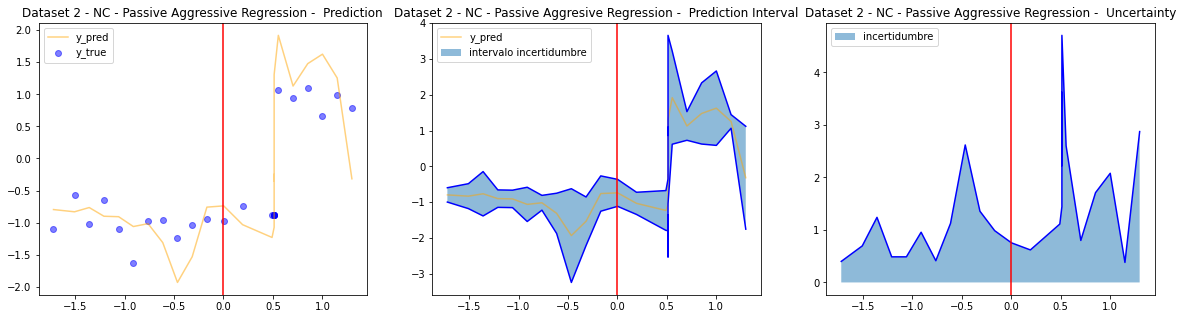

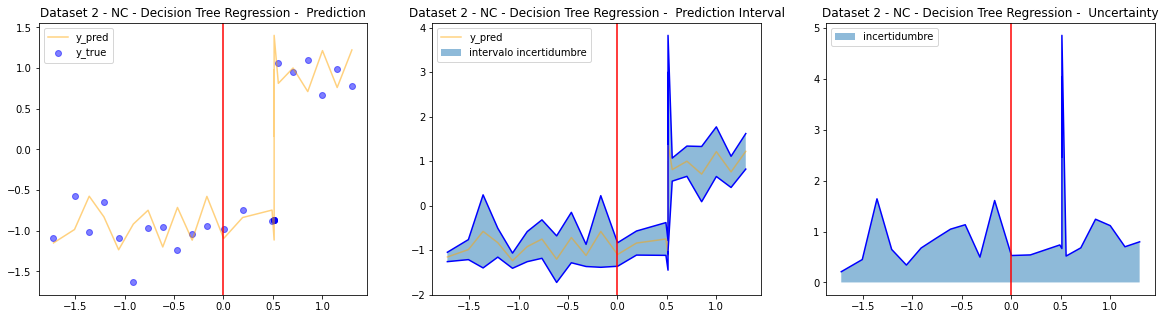

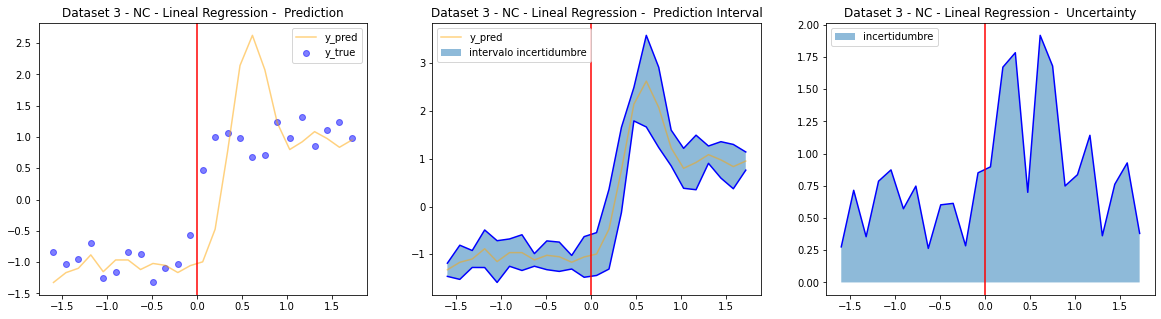

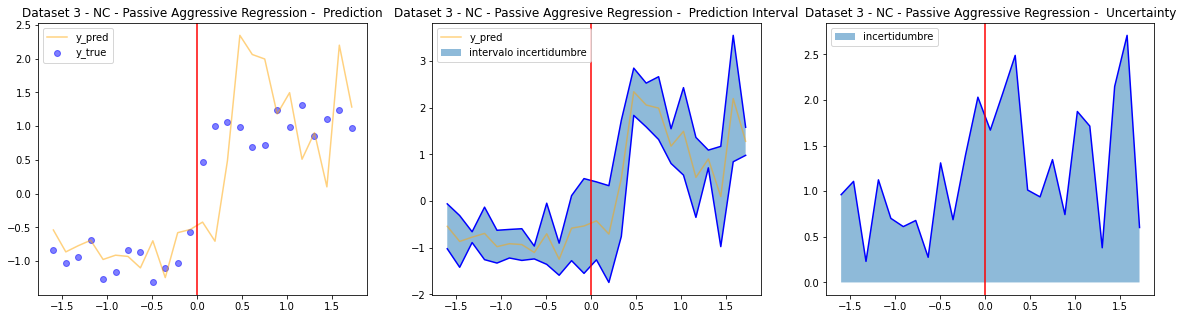

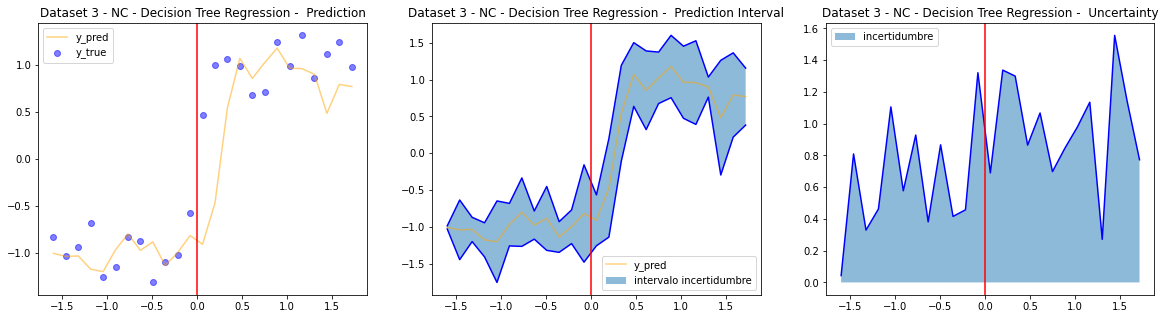

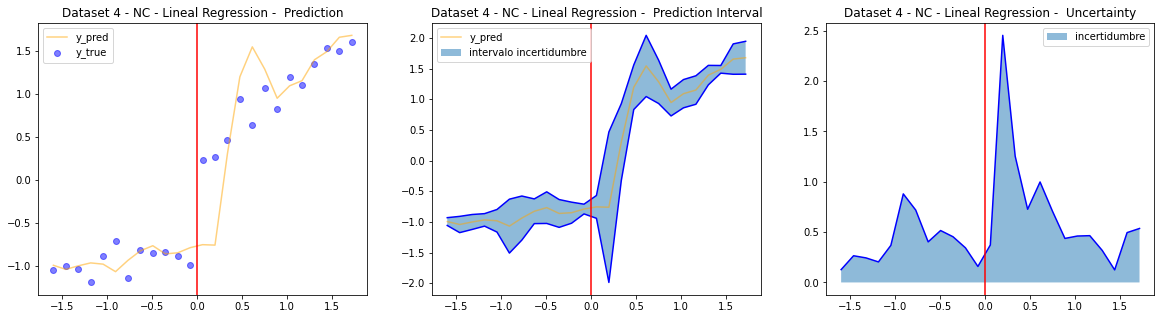

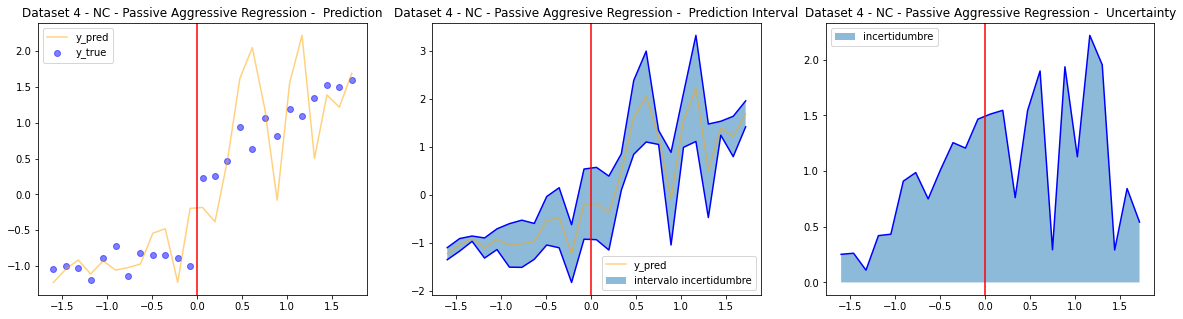

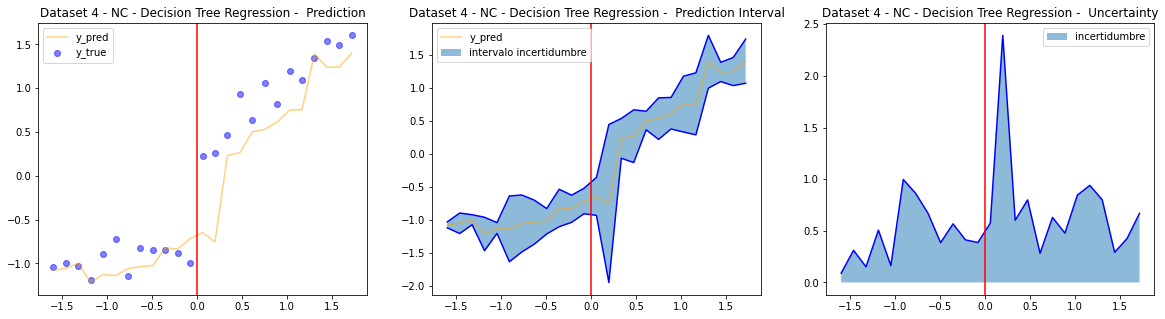

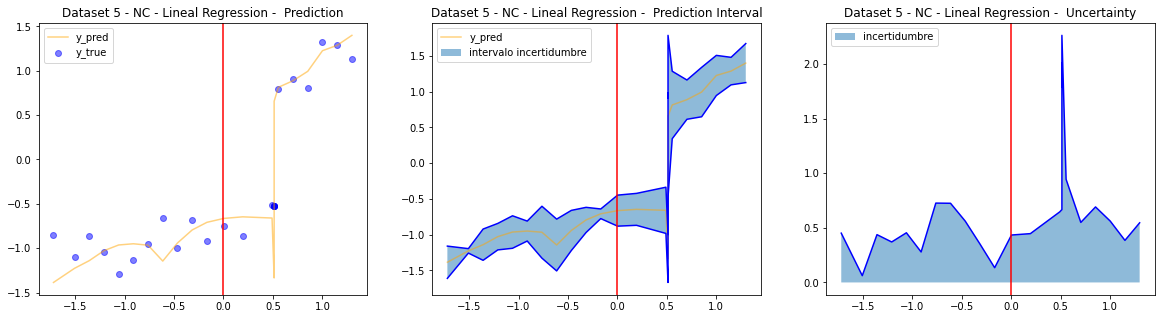

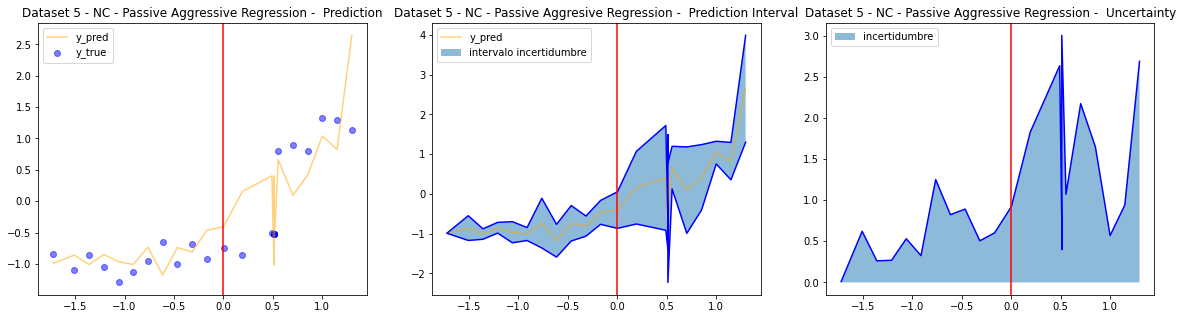

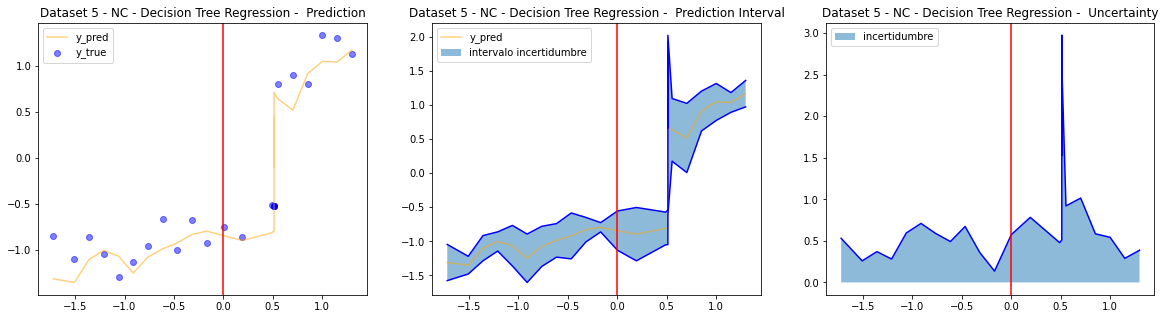

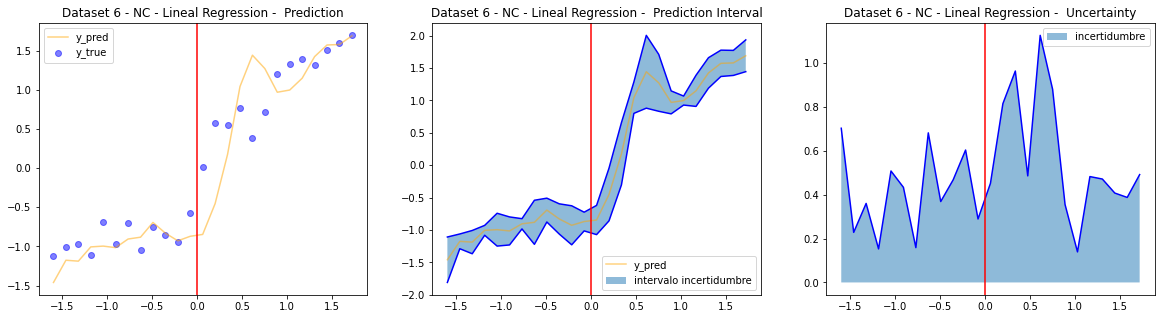

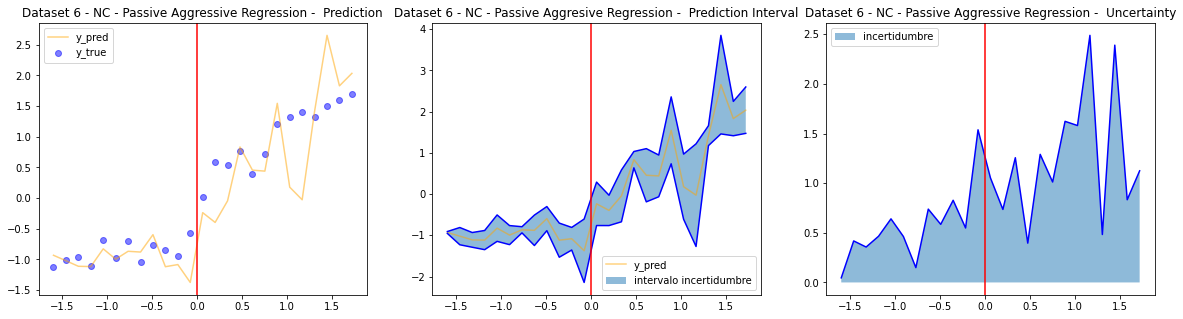

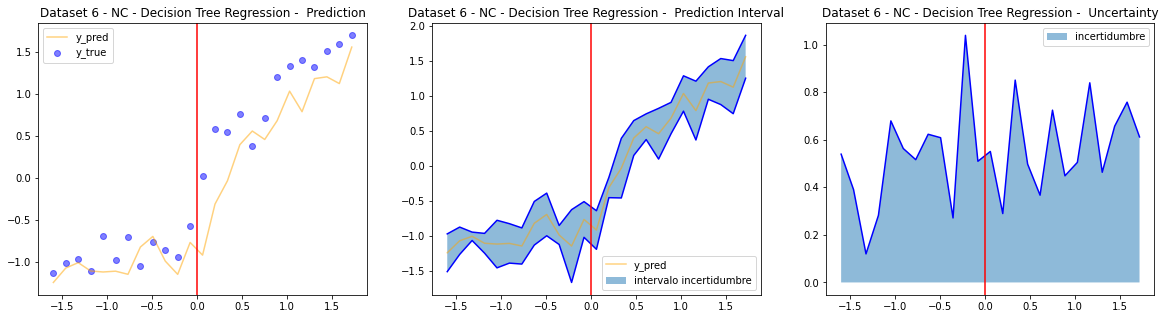

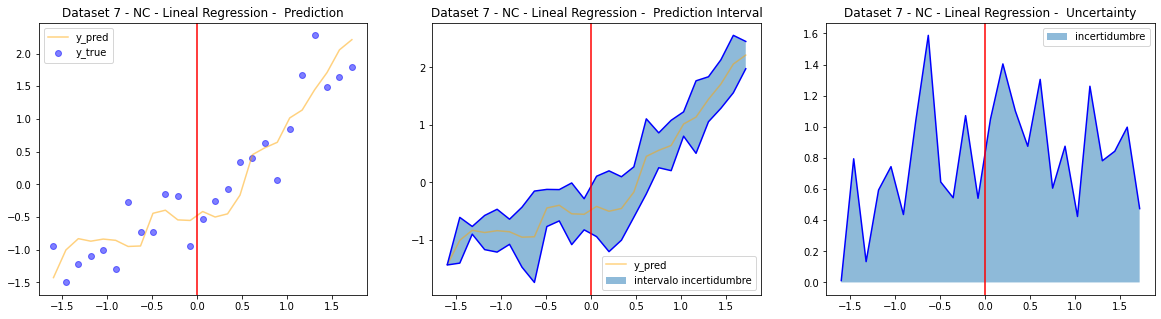

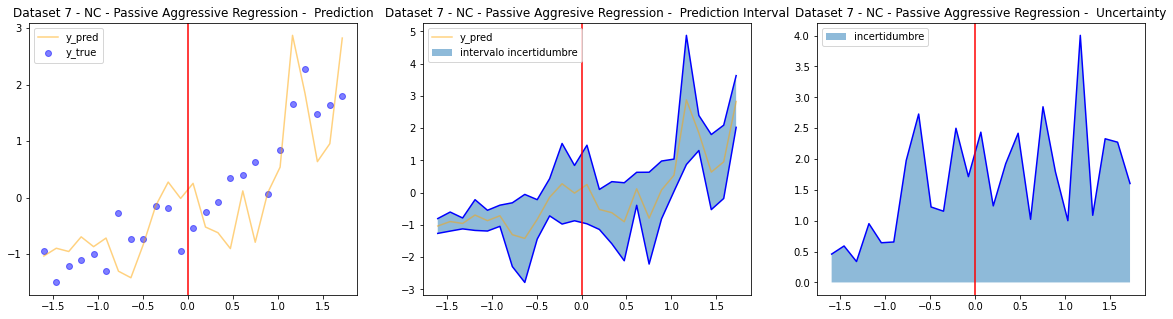

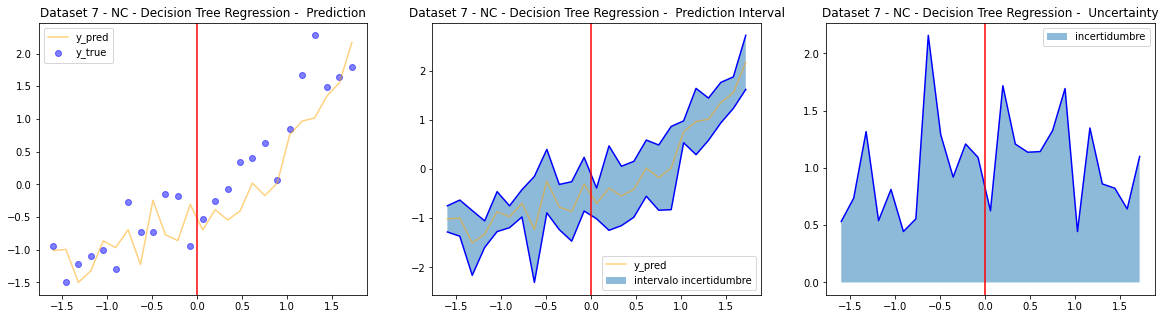

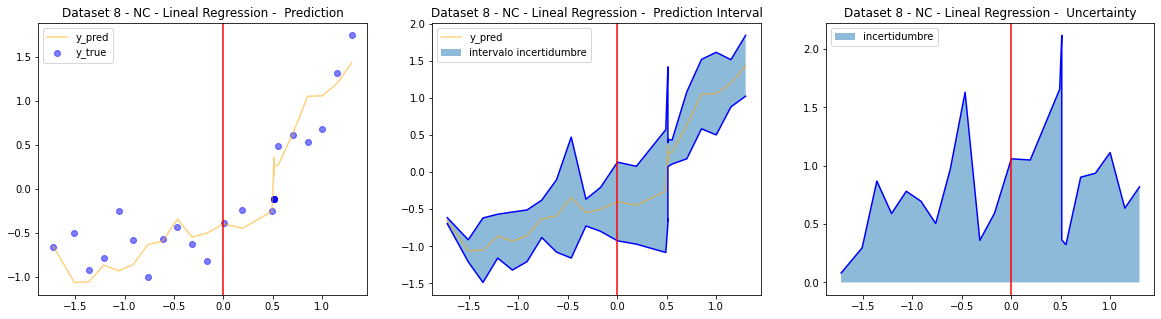

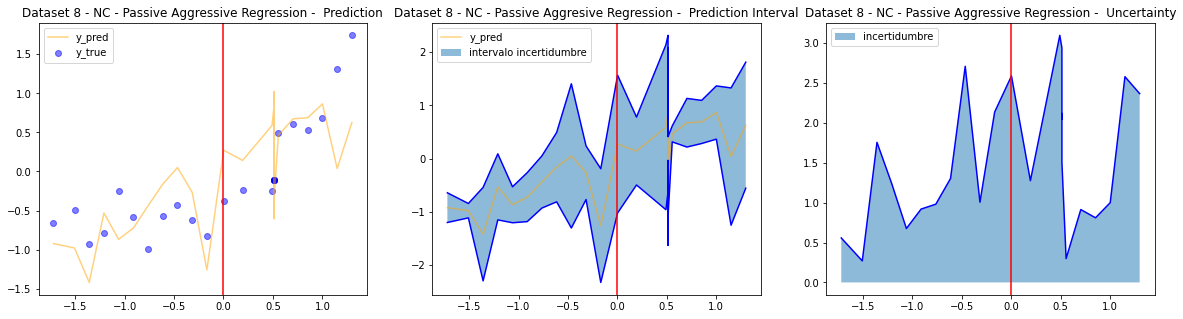

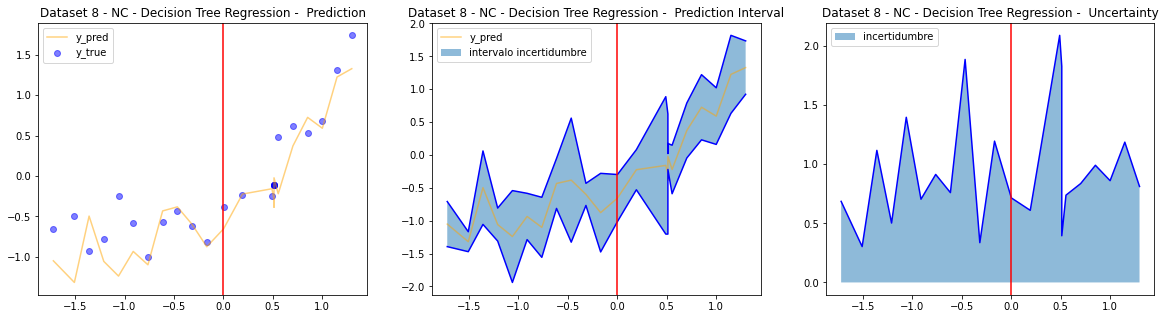

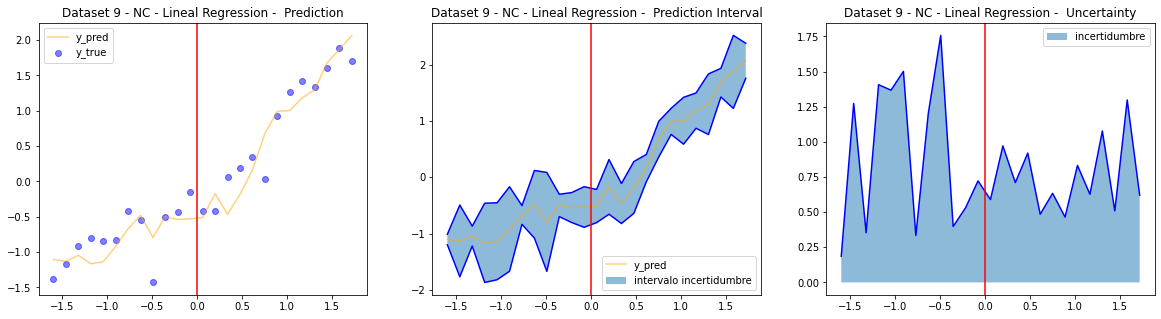

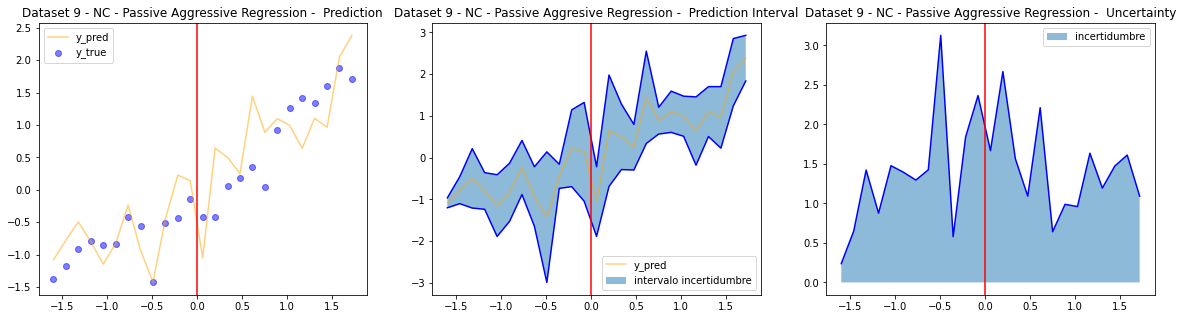

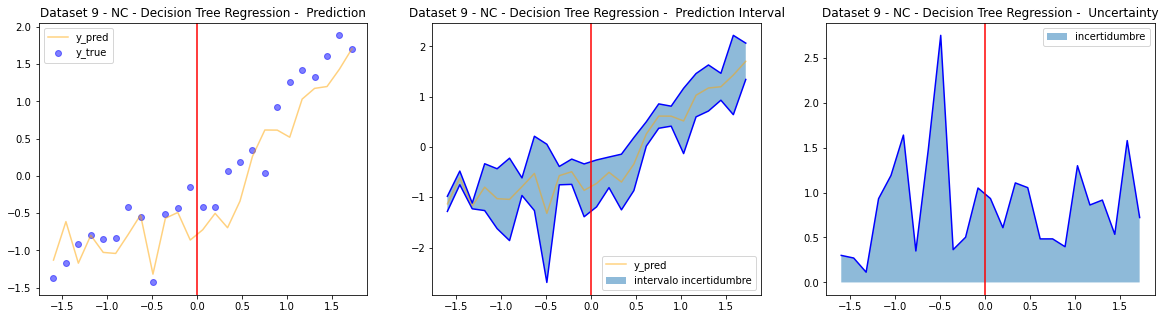

In [ ]:
from nonconformist.cp import IcpRegressor
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory, RegressorNc, RegressorAdapter, AbsErrorErrFunc
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from functools import reduce


def getUncertaintyByNC(dataset, model):
  sorted_dataset = dataset.sort_values(by=['x'])
  target = np.array(sorted_dataset['y']).flatten()
  data = np.array(sorted_dataset.drop(columns='y').values.tolist())

  train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=0.7, shuffle=False)
  cal_data, test_data, cal_target, test_target = train_test_split(test_data, test_target, train_size=1/3, shuffle=False)



  res = {'x': data.flatten().tolist(), 'y':target.tolist(), 'uncert95': [], 'uncert05':[], 'metric': [0 for x in range(len(dataset.index))], 'y_pred':[]}

  

  # Default nonconformity measure
  nc = RegressorNc(RegressorAdapter(model), AbsErrorErrFunc())
  # Inductive conformal regressor
  icp = IcpRegressor(nc)
  # Fit the ICP using the proper training set
  icp.fit(train_data, train_target)
  # Calibrate the ICP using the calibration set
  icp.calibrate(cal_data, cal_target)
  # Desired coverage
  confidence = 0.95
  # Produce predictions for the test set
  prediction = icp.predict(data, significance=(1-confidence))
  res['uncert05'] = prediction[:, 0].tolist()
  res['uncert95'] = prediction[:, 1].tolist()
  res['y_pred'] = model.predict(data).tolist()
  return res

def mergeDict(a,b):
  for key, value in b.items():
    if key in a:
        a[key].extend(value)
    else:
        a[key] = value
  return a

def getUncertaintyByNCOnline(dataset, model):
  count = 25
  dataframes = []
  index_to_split = len(dataset) // count
  start = 0
  end = index_to_split
  for split in range(count):
    temporary_df = dataset.iloc[max(0, start-5*index_to_split):end, :]
    dataframes.append(temporary_df)
    start += index_to_split
    end += index_to_split
    

  data = list(map(lambda d: getUncertaintyByNC(d, model), dataframes))
  data = list(map(lambda d: {'x': [d['x'][-1]], 'y':[d['y'][-1]], 'uncert95': [d['uncert95'][-1]], 'uncert05': [d['uncert05'][-1]], 'metric': [d['metric'][-1]], 'y_pred':[d['y_pred'][-1]] }, data))
  single_data = reduce(mergeDict, data)
  df = pd.DataFrame(single_data)
  return df.sort_values(by=['x'])

  

for index, dataset in  enumerate([item for sublist in datasets for item in sublist]):
  showUncertainty(getUncertaintyByNCOnline(dataset, model = LinearRegression()), drifts=[0], titles=['Dataset {} - NC - Lineal Regression - '.format(index+1), 'Dataset {} - NC - Lineal Regression - '.format(index+1),'Dataset {} - NC - Lineal Regression - '.format(index+1)])
  showUncertainty(getUncertaintyByNCOnline(dataset, model = PassiveAggressiveRegressor()), drifts=[0], titles=['Dataset {} - NC - Passive Aggressive Regression - '.format(index+1), 'Dataset {} - NC - Passive Aggresive Regression - '.format(index+1),'Dataset {} - NC - Passive Aggressive Regression - '.format(index+1)])
  showUncertainty(getUncertaintyByNCOnline(dataset, model = DecisionTreeRegressor()), drifts=[0], titles=['Dataset {} - NC - Decision Tree Regression - '.format(index+1), 'Dataset {} - NC - Decision Tree Regression - '.format(index+1),'Dataset {} - NC - Decision Tree Regression - '.format(index+1)])



### Incertidumbre a partir de la regresión


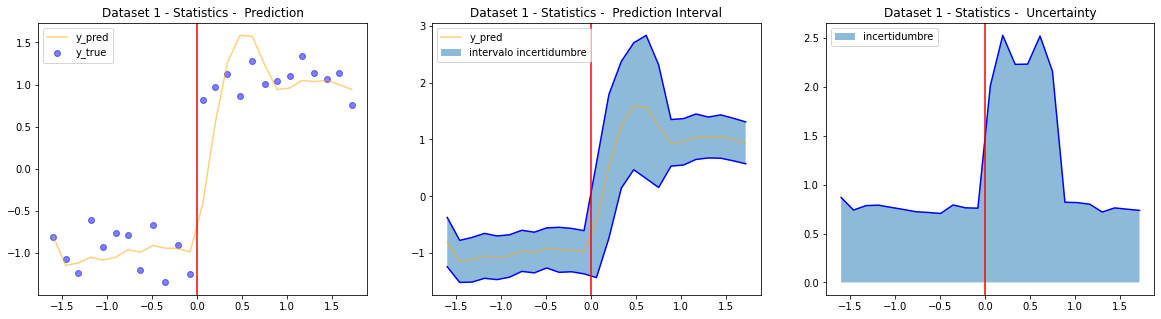

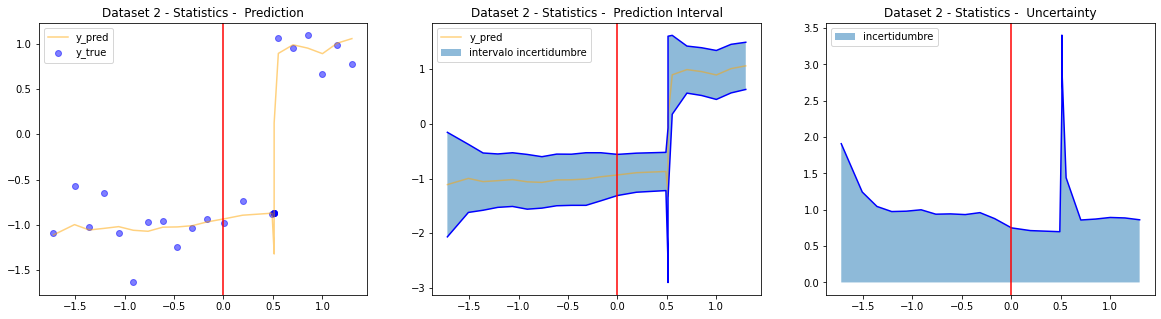

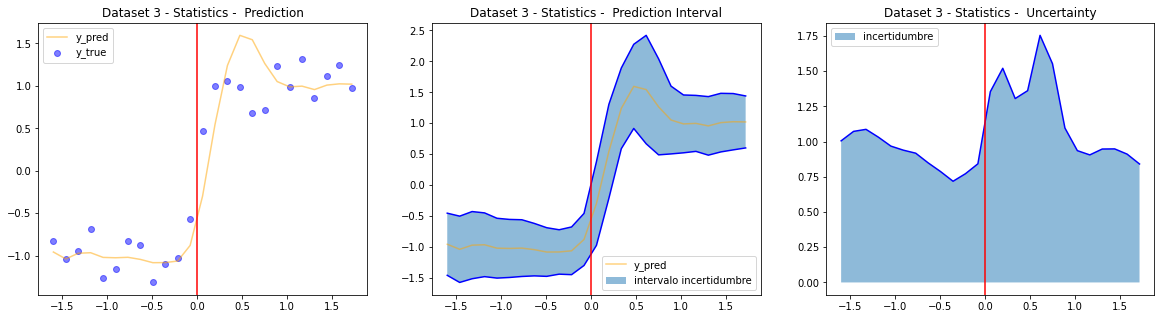

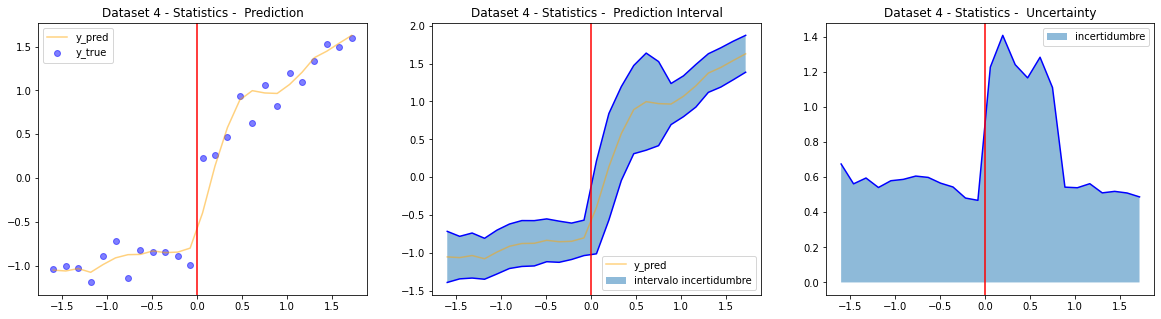

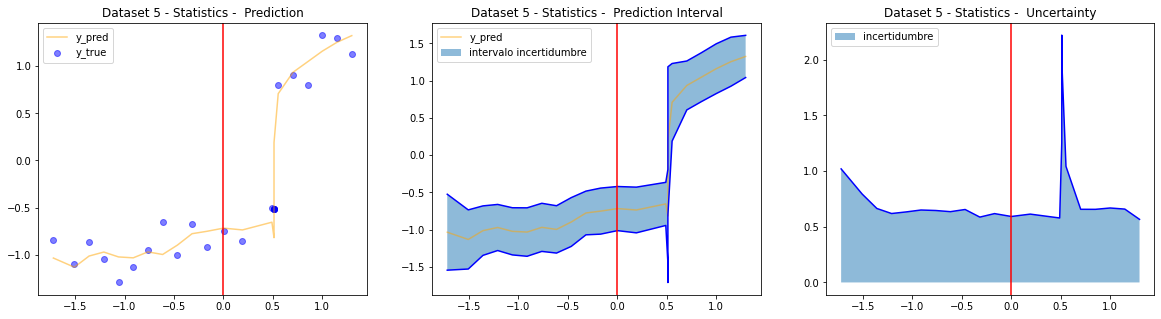

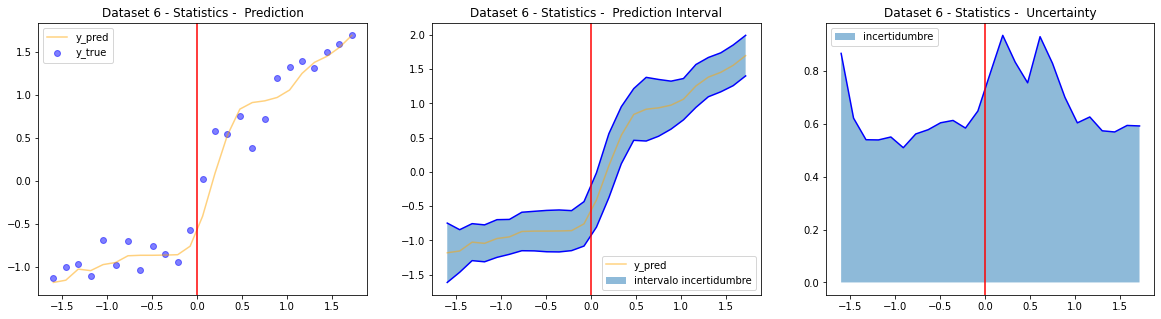

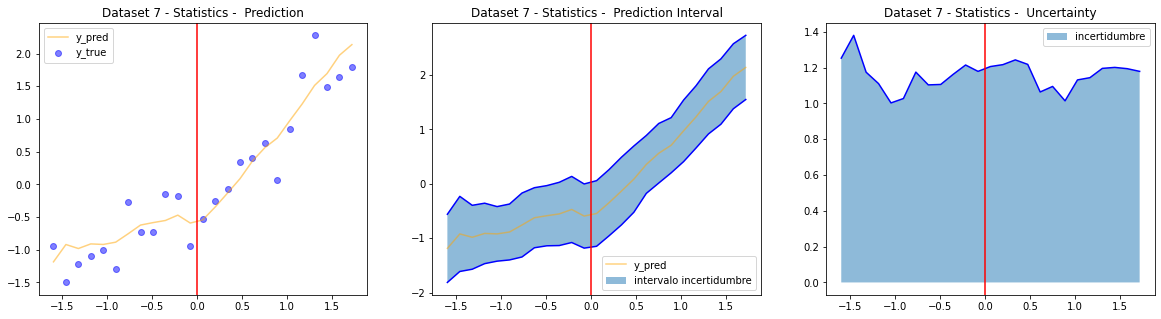

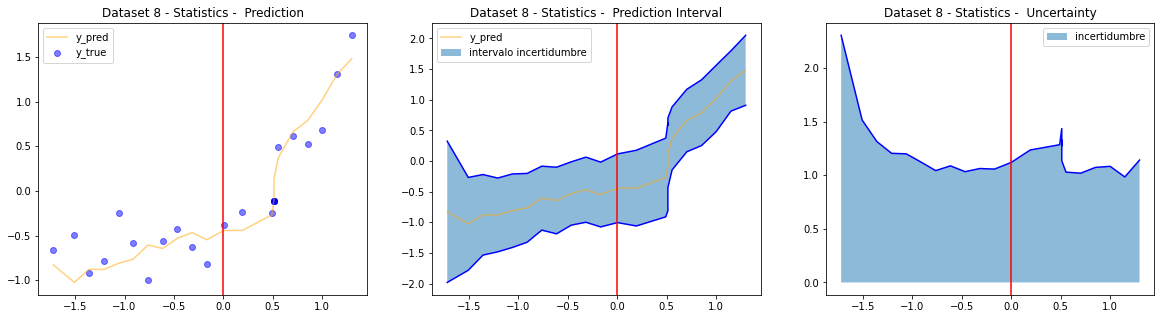

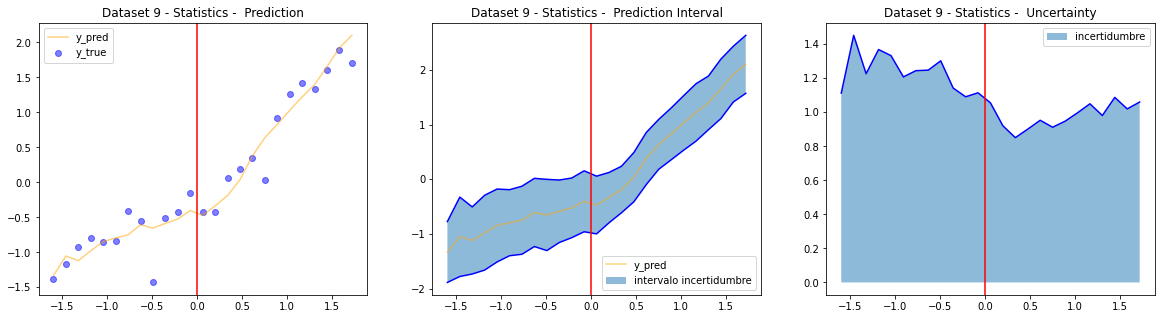

In [ ]:
import pandas as pd
from scipy.stats import t
# https://towardsdatascience.com/prediction-intervals-in-python-64b992317b1a
class CustomLinearRegression:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        # Calculate stats
        self.n = len(x)
        self.x_mean = np.mean(x)
        self.y_mean = np.mean(y)
        self.x_gap = x-self.x_mean
        self.y_gap = y-self.y_mean
        self.ss = np.square(self.x_gap).sum()
        
        # Find coefficients
        self.slope = np.dot(self.x_gap, self.y_gap)/self.ss
        self.intercept = self.y_mean-self.slope*self.x_mean
        
        # Find training error
        y_pred = self.intercept+self.slope*x
        self.se_regression = np.sqrt(
            np.square(y-y_pred).sum()/(self.n-2)
        )
    
    def predict(self, x):
        y_pred = self.intercept+self.slope*x
        return y_pred
    
    def predict_interval(self, x, alpha=0.05):
        t_stat = t.ppf(1-alpha/2, df=self.n-2)
        
        # Calculate interval upper and lower boundaries
        df = pd.DataFrame({'x': x})
        for i, value in df['x'].iteritems():
            se = self.se_regression * np.sqrt(
                1+1/self.n+np.square(value-self.x_mean)/self.ss
            )
            df.loc[i, 'y_pred'] = self.intercept+self.slope*value
            df.loc[i, 'lower'] = df.loc[i, 'y_pred']-t_stat*se
            df.loc[i, 'upper'] = df.loc[i, 'y_pred']+t_stat*se
        return df

def getUncertaintyByStatistic(dataset):
  custom_model = CustomLinearRegression()     
  sorted_dataset = dataset.sort_values(by=['x'])
  Y = np.array(sorted_dataset['y'].values.tolist()).flatten()
  X = np.array(sorted_dataset.drop(columns='y').values.tolist()).flatten()
  custom_model.fit(X, Y)

  custom_pred = custom_model.predict_interval(X)
  
  return {'x':custom_pred['x'].tolist(), 'y': Y.tolist(), 'uncert95': custom_pred['upper'].tolist(), 'uncert05': custom_pred['lower'].tolist(), 'y_pred': custom_pred['y_pred'].tolist()}

def getUncertaintyByStatisticOnline(dataset):
  count = 25
  dataframes = []
  index_to_split = len(dataset) // count
  start = 0
  end = index_to_split
  for split in range(count):
    temporary_df = dataset.iloc[max(0, start-5*index_to_split):end, :]
    dataframes.append(temporary_df)
    start += index_to_split
    end += index_to_split

  data = list(map(lambda d: getUncertaintyByStatistic(d), dataframes))

  data = list(map(lambda d: {'x': [d['x'][-1]], 'y':[d['y'][-1]], 'uncert95': [d['uncert95'][-1]], 'uncert05': [d['uncert05'][-1]], 'y_pred':[d['y_pred'][-1]] }, data))
  single_data = reduce(mergeDict, data)
  df = pd.DataFrame(single_data)
  return df.sort_values(by=['x'])

for index, dataset in  enumerate([item for sublist in datasets for item in sublist]):

  data = getUncertaintyByStatisticOnline(dataset)
  showUncertainty(data, [0], titles=['Dataset {} - Statistics - '.format(index+1), 'Dataset {} - Statistics - '.format(index+1),'Dataset {} - Statistics - '.format(index+1)])

## Detector de Drift por Incertidumbre para Regresión

In [ ]:
from river.drift import ADWIN, HDDM_W, DDM, EDDM, HDDM_A, KSWIN, PageHinkley
import math


def detectDrift(upper, lower, window_size=30, threshold=2):
  mean = utils.Rolling(stats.Mean(), window_size=window_size)
  max = stats.RollingMax(window_size)

  drifts = []
  diffs = np.array(upper) - np.array(lower)

  for index, diff in enumerate(diffs):
    if (mean.update(diff).get() + threshold < diff) and (max.get() == 0):
      max.update(1)
      drifts.append(index)
    else:
      max.update(0)
    
  return drifts 

def showDriftGraphic(data, drift_detections, drift_detector_names, drift_detector_colors, drifts):
  fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
  ax.scatter(data.get('x'), data.get('y'), color="blue", label="y_true", alpha=0.5)
  ax.plot(data.get('x'), data.get('y_pred'), color="orange", label="y_pred", alpha=0.5)
  for drift in drifts:
    ax.axvline(data.get('x')[drift], label="detected drift", color="green")
  for dd, color, name in zip(drift_detections, drift_detector_colors, drift_detector_names):
    for d in dd:
      ax.axvline(d, label=name, color=color)
  ax.legend()


drift_info = []

for index, dataset in  enumerate([item for sublist in datasets for item in sublist]):
 
  data = getUncertaintyByQuantiles(dataset)
  drift_detectors = [ADWIN(), HDDM_W(), EDDM(), HDDM_A(), KSWIN(), PageHinkley()]
  drift_detector_names = ['ADWIN', 'HDDM_W', 'EDDM', 'HDDM_A', 'KSWIN', 'PageHinkley']

  for drift_detector, drift_detector_name in zip(drift_detectors, drift_detector_names):
    dd = []
    for i, x in enumerate(data.get('x')):
      drift_detector.update(x)
      if drift_detector.drift_detected:
        drift_info.append({'algorithm': drift_detector_name, 'dataset': index, 'position': i })
  
  for threshold in [0.3, 0.4, 0.5, 0.7, 1.0, 1.5]:
    for d in detectDrift(data['uncert95'], data['uncert05'], threshold=threshold):
      drift_info.append({'algorithm': 'TFM {}'.format(threshold), 'dataset': index, 'position': d })

drift_dataframe = pd.DataFrame(drift_info)
drift_dataframe['real_drift'] = (drift_dataframe['position'] <= 130) & (drift_dataframe['position'] >= 70)
drift_dataframe['distance'] = abs(100 - drift_dataframe['position'].abs())
drift_dataframe['distance2'] = drift_dataframe['distance'] * drift_dataframe['distance']

algorithms = list(set(drift_dataframe['algorithm'].tolist()))
algorithms.sort()


pd.DataFrame([{'algorithm': algorithm, 
               'Total': len(drift_dataframe[(drift_dataframe['algorithm']==algorithm)]),
               'TP': len(drift_dataframe[(drift_dataframe['algorithm']==algorithm) & (drift_dataframe['real_drift'] == True)]),
               'TP%': "{:10.2f}".format(len(drift_dataframe[(drift_dataframe['algorithm']==algorithm) & (drift_dataframe['real_drift'] == True)]) / len(drift_dataframe[(drift_dataframe['algorithm']==algorithm)])),
               'FP': len(drift_dataframe[(drift_dataframe['algorithm']==algorithm) & (drift_dataframe['real_drift'] == False)]),
               'TP-MSE': "{:10.2f}".format(drift_dataframe[(drift_dataframe['algorithm']==algorithm) & (drift_dataframe['real_drift'] == True)]['distance2'].mean()),
               'TP-RMSE': "{:10.2f}".format(math.sqrt(drift_dataframe[(drift_dataframe['algorithm']==algorithm) & (drift_dataframe['real_drift'] == True)]['distance2'].mean())),
               'TP-MAE': "{:10.2f}".format(drift_dataframe[(drift_dataframe['algorithm']==algorithm) & (drift_dataframe['real_drift'] == True)]['distance'].mean()),} for algorithm in algorithms])



,algorithm,Total,TP,TP%,FP,TP-MSE,TP-RMSE,TP-MAE
0,ADWIN,9,9,1.00,0,729.00,27.00,27.00
1,HDDM_A,27,9,0.33,18,306.00,17.49,17.33
2,HDDM_W,21,0,0.00,21,nan,nan,nan
3,KSWIN,15,9,0.60,6,1.00,1.00,1.00
4,PageHinkley,9,9,1.00,0,45.67,6.76,6.33
5,TFM 0.3,21,8,0.38,13,181.50,13.47,9.50
6,TFM 0.4,15,6,0.40,9,19.17,4.38,4.17
7,TFM 0.5,10,5,0.50,5,30.00,5.48,5.20
8,TFM 0.7,5,4,0.80,1,70.50,8.40,8.00
9,TFM 1.0,2,2,1.00,0,74.50,8.63,8.50


# Classificación

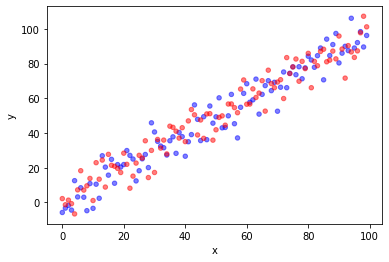

In [ ]:
def generateClassificationDataSet(target_class=1, intercept=[1,0], domain=range(0,100), noise=[0 for x in range(0,100)], columns=['x', 'y', 'target']):
  data = []
  for x, single_noise in zip(domain, noise):
    data.append([x, x*intercept[0]+intercept[1]+ single_noise, target_class])
  return pd.DataFrame(data, columns=columns)

def generateClassificationDataSetWithSuddenDrift(intercept, target, domain=[range(0,100), range(0,100)], noise=[[0 for x in range(0,100)], [0 for x in range(0,100)]], columns=['x', 'y', 'target']):
  datasets = []
  for d in zip(domain, noise, intercept, target):
    dataset = generateClassificationDataSet(intercept=d[2], domain=d[0], noise=d[1], columns=columns, target_class=d[3])
    datasets.append(dataset)
  return reduce(mergeDataSetsSudden, datasets)

df = generateClassificationDataSetWithSuddenDrift(intercept=[[1,0], [1,0]], target=[1,0], noise=[random_state.normal(0,7,100), random_state.normal(0, 7, 100)])
color = np.where(df['target']==1, 'blue', 'red')
df.plot.scatter(x='x', y='y', color=color, alpha=0.5)
